
0: 448x640 1 bowl, 9 apples, 170.2ms
Speed: 3.2ms preprocess, 170.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


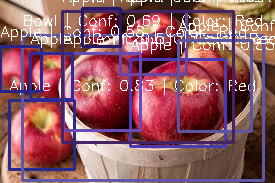

True Positives (TP): 7
False Positives (FP): 3
False Negatives (FN): -6
Accuracy: 1.7500
Precision: 0.7000
Recall: 7.0000
F1 Score: 1.2727


In [ ]:
#main
# Install necessary libraries
!pip install ultralytics

import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow  # Use cv2_imshow for Colab
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans  # Import KMeans from sklearn

# Load the YOLO model
model = YOLO("yolo11n.pt")

# Define a dictionary to map class indices to class names
class_names = {0: 'Person', 1: 'Bicycle', 2: 'Car', 3: 'Motorcycle', 4: 'Airplane',
               5: 'Bus', 6: 'Train', 7: 'Truck', 8: 'Boat', 9: 'Traffic Light',
               10: 'Fire Hydrant', 11: 'Stop Sign', 12: 'Parking Meter',
               13: 'Bench', 14: 'Bird', 15: 'Cat', 16: 'Dog', 17: 'Horse',
               18: 'Sheep', 19: 'Cow', 20: 'Elephant', 21: 'Bear', 22: 'Zebra',
               23: 'Giraffe', 24: 'Backpack', 25: 'Umbrella', 26: 'Handbag',
               27: 'Tie', 28: 'Suitcase', 29: 'Frisbee', 30: 'Skis',
               31: 'Snowboard', 32: 'Sports Ball', 33: 'Kite', 34: 'Baseball Bat',
               35: 'Baseball Glove', 36: 'Skateboard', 37: 'Surfboard',
               38: 'Tennis Racket', 39: 'Bottle', 40: 'Wine Glass',
               41: 'Cup', 42: 'Fork', 43: 'Knife', 44: 'Spoon',
               45: 'Bowl', 46: 'Banana', 47: 'Apple', 48: 'Sandwich',
               49: 'Orange', 50: 'Broccoli', 51: 'Carrot', 52: 'Hot Dog',
               53: 'Pizza', 54: 'Donut', 55: 'Cake', 56: 'Chair',
               57: 'Couch', 58: 'Potted Plant', 59: 'Bed', 60: 'Dining Table',
               61: 'Toilet', 62: 'TV', 63: 'Laptop', 64: 'Mouse',
               65: 'Remote', 66: 'Keyboard', 67: 'Cell Phone', 68: 'Microwave',
               69: 'Oven', 70: 'Toaster', 71: 'Sink', 72: 'Refrigerator',
               73: 'Book', 74: 'Clock', 75: 'Vase', 76: 'Scissors',
               77: 'Teddy Bear', 78: 'Hair Drier', 79: 'Toothbrush'}

# Sample ground truth data for evaluation (modify as per your data)
ground_truth = [
    ('Stop Sign', 50, 50, 150, 150),  # Example ground truth data
    # Add more ground truth objects as needed
]

# Function to get the name of the color from RGB values
def get_color_name(r, g, b):
    colors = {
        'Red': (255, 0, 0),
        'Green': (0, 255, 0),
        'Blue': (0, 0, 255),
        'Yellow': (255, 255, 0),
        'Black': (0, 0, 0),
        'White': (255, 255, 255)
    }
    min_dist = float('inf')
    color_name = 'Undefined'
    for name, (r_c, g_c, b_c) in colors.items():
        dist = ((r - r_c) ** 2 + (g - g_c) ** 2 + (b - b_c) ** 2) ** 0.5
        if dist < min_dist:
            min_dist = dist
            color_name = name
    return color_name

# Function to calculate the dominant color within a bounding box using K-means clustering
def get_dominant_color(image, x1, y1, x2, y2, n_colors=3):
    # Crop the image to the bounding box region
    cropped_image = image[int(y1):int(y2), int(x1):int(x2)]

    # Reshape the cropped image to a 2D array of pixels (N, 3)
    pixels = cropped_image.reshape(-1, 3)

    # Apply K-means clustering to find the most dominant colors
    kmeans = KMeans(n_clusters=n_colors, random_state=0)
    kmeans.fit(pixels)

    # Get the color of the largest cluster (most dominant color)
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    dominant_color = kmeans.cluster_centers_[labels[counts.argmax()]]

    # Convert from BGR to RGB
    dominant_color_rgb = dominant_color[::-1]  # Reverse the order to get RGB

    r, g, b = int(dominant_color_rgb[0]), int(dominant_color_rgb[1]), int(dominant_color_rgb[2])
    color_name = get_color_name(r, g, b)
    return color_name, (r, g, b)

# Perform object detection on an image
image_path = "/content/download (2).jpeg" # Update with your image path
image = cv2.imread(image_path)

if image is not None:
    # Set your desired confidence threshold
    confidence_threshold = 0.3  # Adjust this value as needed

    # Perform YOLO object detection
    results = model(image)

    predicted_boxes = []  # List to store predicted bounding boxes

    # Iterate over each detected object
    for result in results:
        boxes = result.boxes
        for box in boxes:
            if box.conf is not None and box.conf.numpy().item() > confidence_threshold:  # Apply threshold
                x1, y1, x2, y2 = box.xyxy.numpy().flatten()[:4]  # Get box coordinates
                conf = box.conf.numpy().item()  # Confidence score
                cls = int(box.cls.numpy().item())  # Class index

                # Retrieve the object name using the class index
                object_name = class_names.get(cls, 'Unknown')

                # Calculate the dominant color inside the bounding box
                color_name, (r, g, b) = get_dominant_color(image, x1, y1, x2, y2)

                # Draw the bounding box on the image
                cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (r, g, b), 2)

                # Annotate the object class, confidence, and color name on the image
                label = f"{object_name} | Conf: {conf:.2f} | Color: {color_name}"
                cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

                # Store the predicted box for evaluation
                predicted_boxes.append((object_name, x1, y1, x2, y2))

    # Display the final image with bounding boxes and color names
    cv2_imshow(image)  # Use cv2_imshow in Colab

    # Initialize counts for TP, FP, FN
    TP = 0
    FP = 0
    FN = len(ground_truth)  # Start with all ground truth items as FN

    # Calculate TP, FP, and FN
    for pred in predicted_boxes:
        pred_name, pred_x1, pred_y1, pred_x2, pred_y2 = pred
        for gt in ground_truth:
            gt_name, gt_x1, gt_y1, gt_x2, gt_y2 = gt

            # Check for overlap using a simple bounding box intersection check
            if (pred_x1 < gt_x2 and pred_x2 > gt_x1 and
                pred_y1 < gt_y2 and pred_y2 > gt_y1):  # Basic overlap condition
                TP += 1
                FP -= 1  # This means we found a match, so one less FN
                break

    FP = len(predicted_boxes) - TP  # Remaining predicted boxes are false positives
    FN = len(ground_truth) - TP  # Remaining ground truth items are false negatives

    # Calculate Accuracy
    total_predictions = TP + FP + FN
    accuracy = TP / total_predictions if total_predictions > 0 else 0

    # Calculate Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Calculate Recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1 Score
    if precision + recall > 0:
        f1_score_value = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score_value = 0

    # Print the evaluation metrics
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score_value:.4f}")
else:
    print("Image not found. Please check the image path.")
